In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class LinearCNN(nn.Module):
    def __init__(self, input_dim, out_channel, patch_num):
        super(LinearCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, out_channel*2, int(input_dim/patch_num), int(input_dim/patch_num))
        self.out_channel = out_channel

    def forward(self, x):
        x = self.conv1(x)
        x = torch.pow(x, 3)
        x = torch.nn.functional.relu(x)
        x = torch.sum(x,2)
        output = torch.stack([torch.sum(x[:,:self.out_channel],1), torch.sum(x[:,self.out_channel:],1)]).transpose(1,0)
        return output

### Data Generation

In [ ]:
DATA_NUM = 400
CLUSTER_NUM = 1
PATCH_NUM = 2
PATCH_LEN = 50
Noiselevel = 1.0
bmu = 1

In [ ]:
features = torch.zeros(CLUSTER_NUM, PATCH_LEN)
pos = 0
for i in range(CLUSTER_NUM):
    features[i,pos] = bmu
    pos+=1


In [ ]:
data = []
labels = []

for i in range(DATA_NUM*2):
    y = np.random.choice([-1,1], 1)[0] 
    k = torch.randint(0, CLUSTER_NUM, (1,))
    xi = torch.tensor(np.random.normal(0, Noiselevel, size=(PATCH_LEN))) 
    # make it orthogonal 
    xi[:CLUSTER_NUM] = 0
    
    x = torch.stack([features[k][0]*y, xi])
    
    # random permutation
    idx = torch.randperm(len(x))
    x = x[idx].flatten()

    data.append(x)
    labels.append(y)


In [ ]:
data = torch.stack(data)
print(data.shape)

labels = torch.tensor(labels)
labels[labels==-1] = 0
print(labels.shape)

torch.Size([800, 100])
torch.Size([800])


In [ ]:
training_data = data[:DATA_NUM,:].unsqueeze(1).float()
test_data = data[DATA_NUM::].unsqueeze(1).float()
print(training_data.shape)
print(training_data.shape, test_data.shape)

training_labels = labels[:DATA_NUM]
test_labels = labels[DATA_NUM:]
print(training_labels.shape, test_labels.shape)

torch.Size([400, 1, 100])
torch.Size([400, 1, 100]) torch.Size([400, 1, 100])
torch.Size([400]) torch.Size([400])


### Training

In [ ]:
import torch.optim as optim


In [ ]:
def train(model, criterion, data, labels, optimizer, epochs):

    for epoch in range(epochs):  

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # if epoch%500 == 0:   
        #     print('Epoch %d --- loss: %.3f' %
        #             (epoch + 1, loss.item()))
        #     #test(model, criterion, test_data, test_labels, num_epochs)

    # print('Finished Training')
    

def test(model, criterion, data, labels, epochs):
    correct = 0
    
    with torch.no_grad():
        outputs = model(data)
    #     predicted = torch.max(outputs.data, 1).indices
    #     correct += (predicted == labels).sum().item()
    # outputt = 100*correct / data.shape[0]
    outputt = criterion(outputs, labels)
    # print('Accuracy of the network on the %d test images: %.4f %%' % (data.shape[0],
    #     outputt))
    return outputt

In [ ]:
num_epochs = 5000

my_mixture = LinearCNN(200, 10, PATCH_NUM) #input_dim, out_channel (m), cluter_num, patch_num
criterion = torch.nn.CrossEntropyLoss() 
optimizer = optim.SGD(my_mixture.parameters(), lr=0.01, momentum=0, weight_decay=0)

train(my_mixture, criterion, training_data, training_labels, optimizer, num_epochs)

In [ ]:
test(my_mixture, criterion, training_data, training_labels, num_epochs)
test(my_mixture, criterion, test_data, test_labels, num_epochs)

tensor(0.2061)

In [ ]:
num_epochs = 50
DATA_NUM = 100
CLUSTER_NUM = 1
PATCH_NUM = 2
sigma = 20
# PATCH_LEN = 500
PATCH_LEN = sigma*sigma
Noiselevel = 1.0

features = torch.zeros(CLUSTER_NUM, PATCH_LEN)
pos = 0
for i in range(CLUSTER_NUM):
    features[i,pos] = 1
    pos+=1

strength = []
test_acc = []
train_acc = []


Data_train = np.random.rand(100, 100)
Data_test = np.random.rand(100, 100)
for s in range(100):
  print(s)
  bmu = 0.01*s*sigma
  strength.append(bmu/sigma)
  for t in range(100):
    test1 = 0
    train1 = 0
    DATA_NUM = t + 1
    for j in range(10):
      data = []
      labels = []
      for i in range(DATA_NUM*2):
        y = np.random.choice([-1,1], 1)[0] 
        k = torch.randint(0, CLUSTER_NUM, (1,))
        xi = torch.tensor(np.random.normal(0, Noiselevel, size=(PATCH_LEN))) 
        # orthogonal
        xi[:CLUSTER_NUM] = 0    
        x = torch.stack([features[k][0]*bmu*y, xi])    
        # random permutation
        idx = torch.randperm(len(x))
        x = x[idx].flatten()
        data.append(x)
        labels.append(y)
      data = torch.stack(data)
      labels = torch.tensor(labels)
      labels[labels==-1] = 0

      training_data = data[:DATA_NUM,:].unsqueeze(1).float()
      test_data = data[DATA_NUM::].unsqueeze(1).float()
      training_labels = labels[:DATA_NUM]
      test_labels = labels[DATA_NUM:]
      my_mixture = LinearCNN(2*PATCH_LEN, 10, PATCH_NUM) #input_dim, out_channel (m), cluter_num, patch_num
      criterion = torch.nn.CrossEntropyLoss() 
      optimizer = optim.SGD(my_mixture.parameters(), lr= 0.01, momentum=0, weight_decay=0)
      train(my_mixture, criterion, training_data, training_labels, optimizer, num_epochs)
      train1 += test(my_mixture, criterion, training_data, training_labels, num_epochs)
      test1 += test(my_mixture, criterion, test_data, test_labels, num_epochs)
    # test_acc.append(test1/10)
    # train_acc.append(train1/10)
    Data_train[t][s] = train1/10
    Data_test[t][s] = test1/10

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
import seaborn as sns

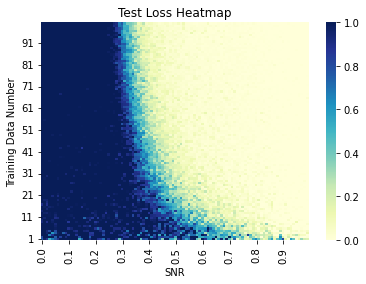

In [ ]:
# Data_test1 = Data_test[50:100, 0:50]
# Data_train1 = Data_train[50:100, 0:50]

A1 =  np.multiply(range(100), 0.01)
A2 =  range(1, 101)
xlabels = ['{:3.1f}'.format(x) for x in A1]
# ylabels = ['{:3.1f}'.format(y) for y in A2]
ylabels = A2
ax = sns.heatmap(Data_test, xticklabels = xlabels, yticklabels = ylabels, cmap = "YlGnBu", vmax = 1)
# ax = sns.heatmap(Data_test, cmap = "YlGnBu")
ax.invert_yaxis()

ax.set_title("Test Loss Heatmap")
ax.set_xlabel('SNR')
ax.set_ylabel('Training Data Number')
ax.set_xticks(ax.get_xticks()[::10])
ax.set_xticklabels(xlabels[::10])
ax.set_yticks(ax.get_yticks()[::10])
ax.set_yticklabels(ylabels[::10])
plt.show()

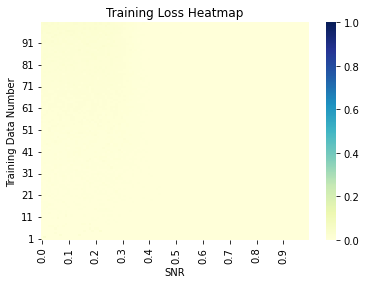

In [ ]:
# Data_test1 = Data_test[50:100, 0:50]
# Data_train1 = Data_train[50:100, 0:50]

A1 =  np.multiply(range(100), 0.01)
A2 =  range(1, 101)
xlabels = ['{:3.1f}'.format(x) for x in A1]
# ylabels = ['{:3.1f}'.format(y) for y in A2]
ylabels = A2
ax = sns.heatmap(Data_train, xticklabels = xlabels, yticklabels = ylabels, cmap = "YlGnBu", vmax = 1)
# ax = sns.heatmap(Data_test, cmap = "YlGnBu")
ax.invert_yaxis()

ax.set_title("Training Loss Heatmap")
ax.set_xlabel('SNR')
ax.set_ylabel('Training Data Number')
ax.set_xticks(ax.get_xticks()[::10])
ax.set_xticklabels(xlabels[::10])
ax.set_yticks(ax.get_yticks()[::10])
ax.set_yticklabels(ylabels[::10])
plt.show()

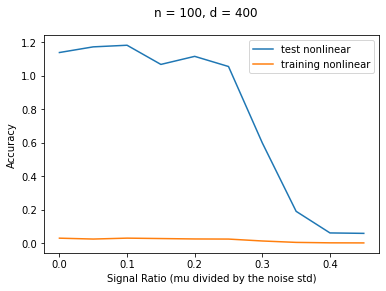

In [ ]:
plt.suptitle('n = 100, d = 400')
plt.plot(strength,test_acc, label = 'test nonlinear')
plt.plot(strength,train_acc, label = 'training nonlinear')
plt.xlabel('Signal Ratio (mu divided by the noise std)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()